# Exponential Degradation Model

In [61]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight

from scipy import optimize

In [ ]:
def prepare_data():
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [ ]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
sc = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = sc.fit_transform(df_train[feats])
df_test[feats] = sc.transform(df_test[feats])

In [6]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RUL
0,1,1,-0.080460,-0.666667,-1.0,-1.0,-0.632530,-0.186396,-0.380486,-1.0,...,-0.588235,-0.600784,-0.272028,-1.0,-0.333333,-1.0,-1.0,0.426357,0.449323,191
1,1,2,0.218391,-0.500000,-1.0,-1.0,-0.433735,-0.093961,-0.294733,-1.0,...,-0.441176,-0.674373,-0.177376,-1.0,-0.333333,-1.0,-1.0,0.333333,0.462027,190
2,1,3,-0.494253,0.500000,-1.0,-1.0,-0.313253,-0.260955,-0.258947,-1.0,...,-0.558824,-0.656414,-0.285110,-1.0,-0.666667,-1.0,-1.0,0.255814,0.242751,189
3,1,4,0.080460,0.000000,-1.0,-1.0,-0.313253,-0.487683,-0.337610,-1.0,...,-0.411765,-0.650222,-0.666795,-1.0,-0.333333,-1.0,-1.0,0.147287,0.324772,188
4,1,5,-0.218391,-0.333333,-1.0,-1.0,-0.301205,-0.485066,-0.190749,-1.0,...,-0.529412,-0.650532,-0.195845,-1.0,-0.166667,-1.0,-1.0,0.178295,0.409003,187


In [7]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,-1.0,0.090361,-0.378679,-0.461175,-1.0,...,0.292111,-0.558824,-0.735680,-0.382070,-1.0,-0.333333,-1.0,-1.0,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-1.0,-0.698795,-0.240898,-0.555368,-1.0,...,0.479744,-0.470588,-0.590463,-0.573682,-1.0,-0.166667,-1.0,-1.0,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-1.0,-0.246988,-0.306736,-0.355503,-1.0,...,0.398721,-0.558824,-0.688719,-0.082724,-1.0,-0.166667,-1.0,-1.0,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-1.0,-0.259036,-0.429693,-0.183997,-1.0,...,0.147122,-0.500000,-0.659820,-0.485956,-1.0,-0.500000,-1.0,-1.0,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-1.0,-0.216867,-0.295836,-0.335922,-1.0,...,0.475480,-0.558824,-0.694499,-0.398230,-1.0,-0.666667,-1.0,-1.0,0.317829,0.432753


### Taking rolling averages to reduce noise

In [8]:
window = 5

In [9]:
df_train_mean = df_train.groupby('UnitNumber')[feats].rolling(window = window).mean()
df_train_mean = df_train_mean.reset_index()
df_train_mean.dropna(inplace = True)
df_train_mean.drop(['level_1'], axis = 1, inplace = True)
df_train_mean.head()

,UnitNumber,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
4,1,-0.098851,-0.200000,-1.0,-1.0,-0.398795,-0.302812,-0.292505,-1.0,1.0,...,0.531770,-0.505882,-0.646465,-0.319431,-1.0,-0.366667,-1.0,-1.0,0.268217,0.377575
5,1,-0.181609,-0.100000,-1.0,-1.0,-0.365060,-0.348419,-0.307562,-1.0,1.0,...,0.533475,-0.500000,-0.658375,-0.332820,-1.0,-0.400000,-1.0,-1.0,0.243411,0.348799
6,1,-0.202299,0.033333,-1.0,-1.0,-0.325301,-0.344059,-0.343822,-1.0,1.0,...,0.536887,-0.523529,-0.656662,-0.385764,-1.0,-0.400000,-1.0,-1.0,0.274419,0.323281
7,1,-0.181609,0.033333,-1.0,-1.0,-0.300000,-0.387922,-0.365631,-1.0,1.0,...,0.541151,-0.523529,-0.661121,-0.401462,-1.0,-0.366667,-1.0,-1.0,0.280620,0.304722
8,1,-0.179310,0.066667,-1.0,-1.0,-0.327711,-0.316503,-0.413369,-1.0,1.0,...,0.449893,-0.541176,-0.677923,-0.394382,-1.0,-0.366667,-1.0,-1.0,0.333333,0.322784


In [10]:
df_train_mean.shape

(20231, 25)

### Selecting features using monotonicity

\begin{equation*}
Monotonicity (x) = \frac{1}{m}\sum_{j=1}^m \frac{|\text{number of positive diff} (x_j) - \text{number of negative diff} (x_j)|}{n-1}
\end{equation*}

where n is the length of data and m is the number of units. diff(x_j) is the lag difference of specific feature. 

In [11]:
df_lag = df_train_mean.groupby('UnitNumber').diff(1)
df_lag['UnitNumber'] = df_train_mean['UnitNumber']
df_lag.dropna(inplace = True)
df_lag = df_lag.reset_index(drop = True)
df_lag.head()

,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,...,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,UnitNumber
0,-0.082759,1.000000e-01,0.0,0.0,0.033735,-0.045607,-0.015057,0.0,0.0,0.019968,...,0.005882,-0.011910,-0.013390,0.0,-0.033333,0.0,0.0,-0.024806,-0.028777,1
1,-0.020690,1.333333e-01,0.0,0.0,0.039759,0.004360,-0.036259,0.0,0.0,0.038003,...,-0.023529,0.001713,-0.052943,0.0,0.000000,0.0,0.0,0.031008,-0.025518,1
2,0.020690,6.938894e-18,0.0,0.0,0.025301,-0.043863,-0.021810,0.0,0.0,-0.026409,...,0.000000,-0.004459,-0.015698,0.0,0.033333,0.0,0.0,0.006202,-0.018558,1
3,0.002299,3.333333e-02,0.0,0.0,-0.027711,0.071419,-0.047738,0.0,0.0,-0.048953,...,-0.017647,-0.016803,0.007080,0.0,0.000000,0.0,0.0,0.052713,0.018061,1
4,-0.032184,1.000000e-01,0.0,0.0,-0.079518,0.073163,-0.038893,0.0,0.0,-0.026409,...,0.011765,-0.009124,-0.001231,0.0,0.000000,0.0,0.0,0.015504,0.035902,1


In [12]:
def monotonicity(data):
    
    num_pos = data[data > 0].shape[0]
    num_neg = data[data < 0].shape[0]
    tot_n = data.shape[0] - 1
    
    mon_val = np.abs(num_pos - num_neg)/tot_n
    return mon_val

In [13]:
mon_df = pd.DataFrame(columns = ['feature', 'monotonicity_val'])

for col in feats:
    mon_val = []
    for unit in df_lag.UnitNumber.unique():
        mon_val.append(monotonicity(df_lag.loc[df_lag.UnitNumber == unit, col]))
    mon_df = mon_df.append({'feature': col, 'monotonicity_val': np.mean(mon_val)}, ignore_index = True)

In [14]:
mon_df = mon_df.sort_values(by = 'monotonicity_val', ascending = False)
mon_df.head()

,feature,monotonicity_val
16,SensorMeasure14,0.157243
11,SensorMeasure9,0.147807
13,SensorMeasure11,0.116696
14,SensorMeasure12,0.105777
6,SensorMeasure4,0.092576


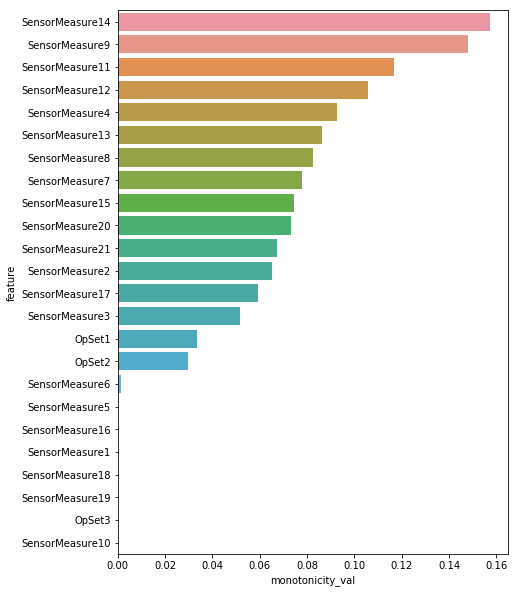

In [15]:
fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = mon_df.feature, x = mon_df.monotonicity_val)

Features with monotonicity value larger than 0.08 are selected.

In [16]:
feats = mon_df.feature[mon_df.monotonicity_val > 0.08]
feats

16    SensorMeasure14
11     SensorMeasure9
13    SensorMeasure11
14    SensorMeasure12
6      SensorMeasure4
15    SensorMeasure13
10     SensorMeasure8
Name: feature, dtype: object

In [17]:
len(feats)

7

### PCA to fuse features

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=3)

pca_data = pca.fit_transform(df_train_mean[feats])

pca_df = pd.DataFrame(pca_data, columns = ['pc1', 'pc2', 'pc3'])
pca_df['UnitNumber'] = df_train_mean.UnitNumber.values
pca_df['cycle'] = pca_df.groupby('UnitNumber').cumcount()+1
pca_df['RUL'] = pca_df.groupby('UnitNumber').cycle.transform('max') - pca_df.cycle
pca_df.head()

,pc1,pc2,pc3,UnitNumber,cycle,RUL
0,-0.496369,-0.132625,-0.122027,1,1,187
1,-0.549425,-0.137713,-0.118303,1,2,186
2,-0.594405,-0.115734,-0.093867,1,3,185
3,-0.628940,-0.124971,-0.079502,1,4,184
4,-0.603982,-0.132597,0.020663,1,5,183


### Visualizing principal components

In [20]:
pcs = ['pc1', 'pc2', 'pc3']

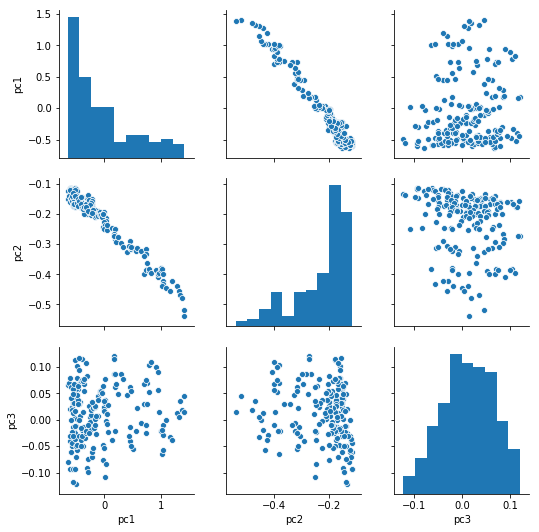

In [21]:
sns.pairplot(data = pca_df[pca_df.UnitNumber == 1], x_vars= pcs, y_vars = pcs)

#### Choosing PC1 and PC2 and plotting

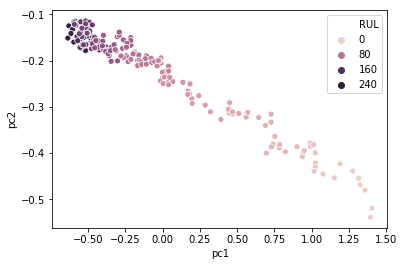

In [23]:
sns.scatterplot(data = pca_df[pca_df.UnitNumber == 1], x = "pc1", y = "pc2", hue = "RUL")

#### Considering PC1 as a health indicator and visualizing against cycle

Text(0, 0.5, 'Health Indicator')

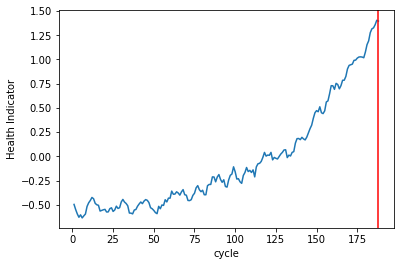

In [37]:
fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "cycle", y = "pc1", ax = ax)
plt.axvline(pca_df[pca_df.UnitNumber == 1].cycle.max(), color = 'r')
ax.set_ylabel("Health Indicator")

#### visualizing health indicators of all units

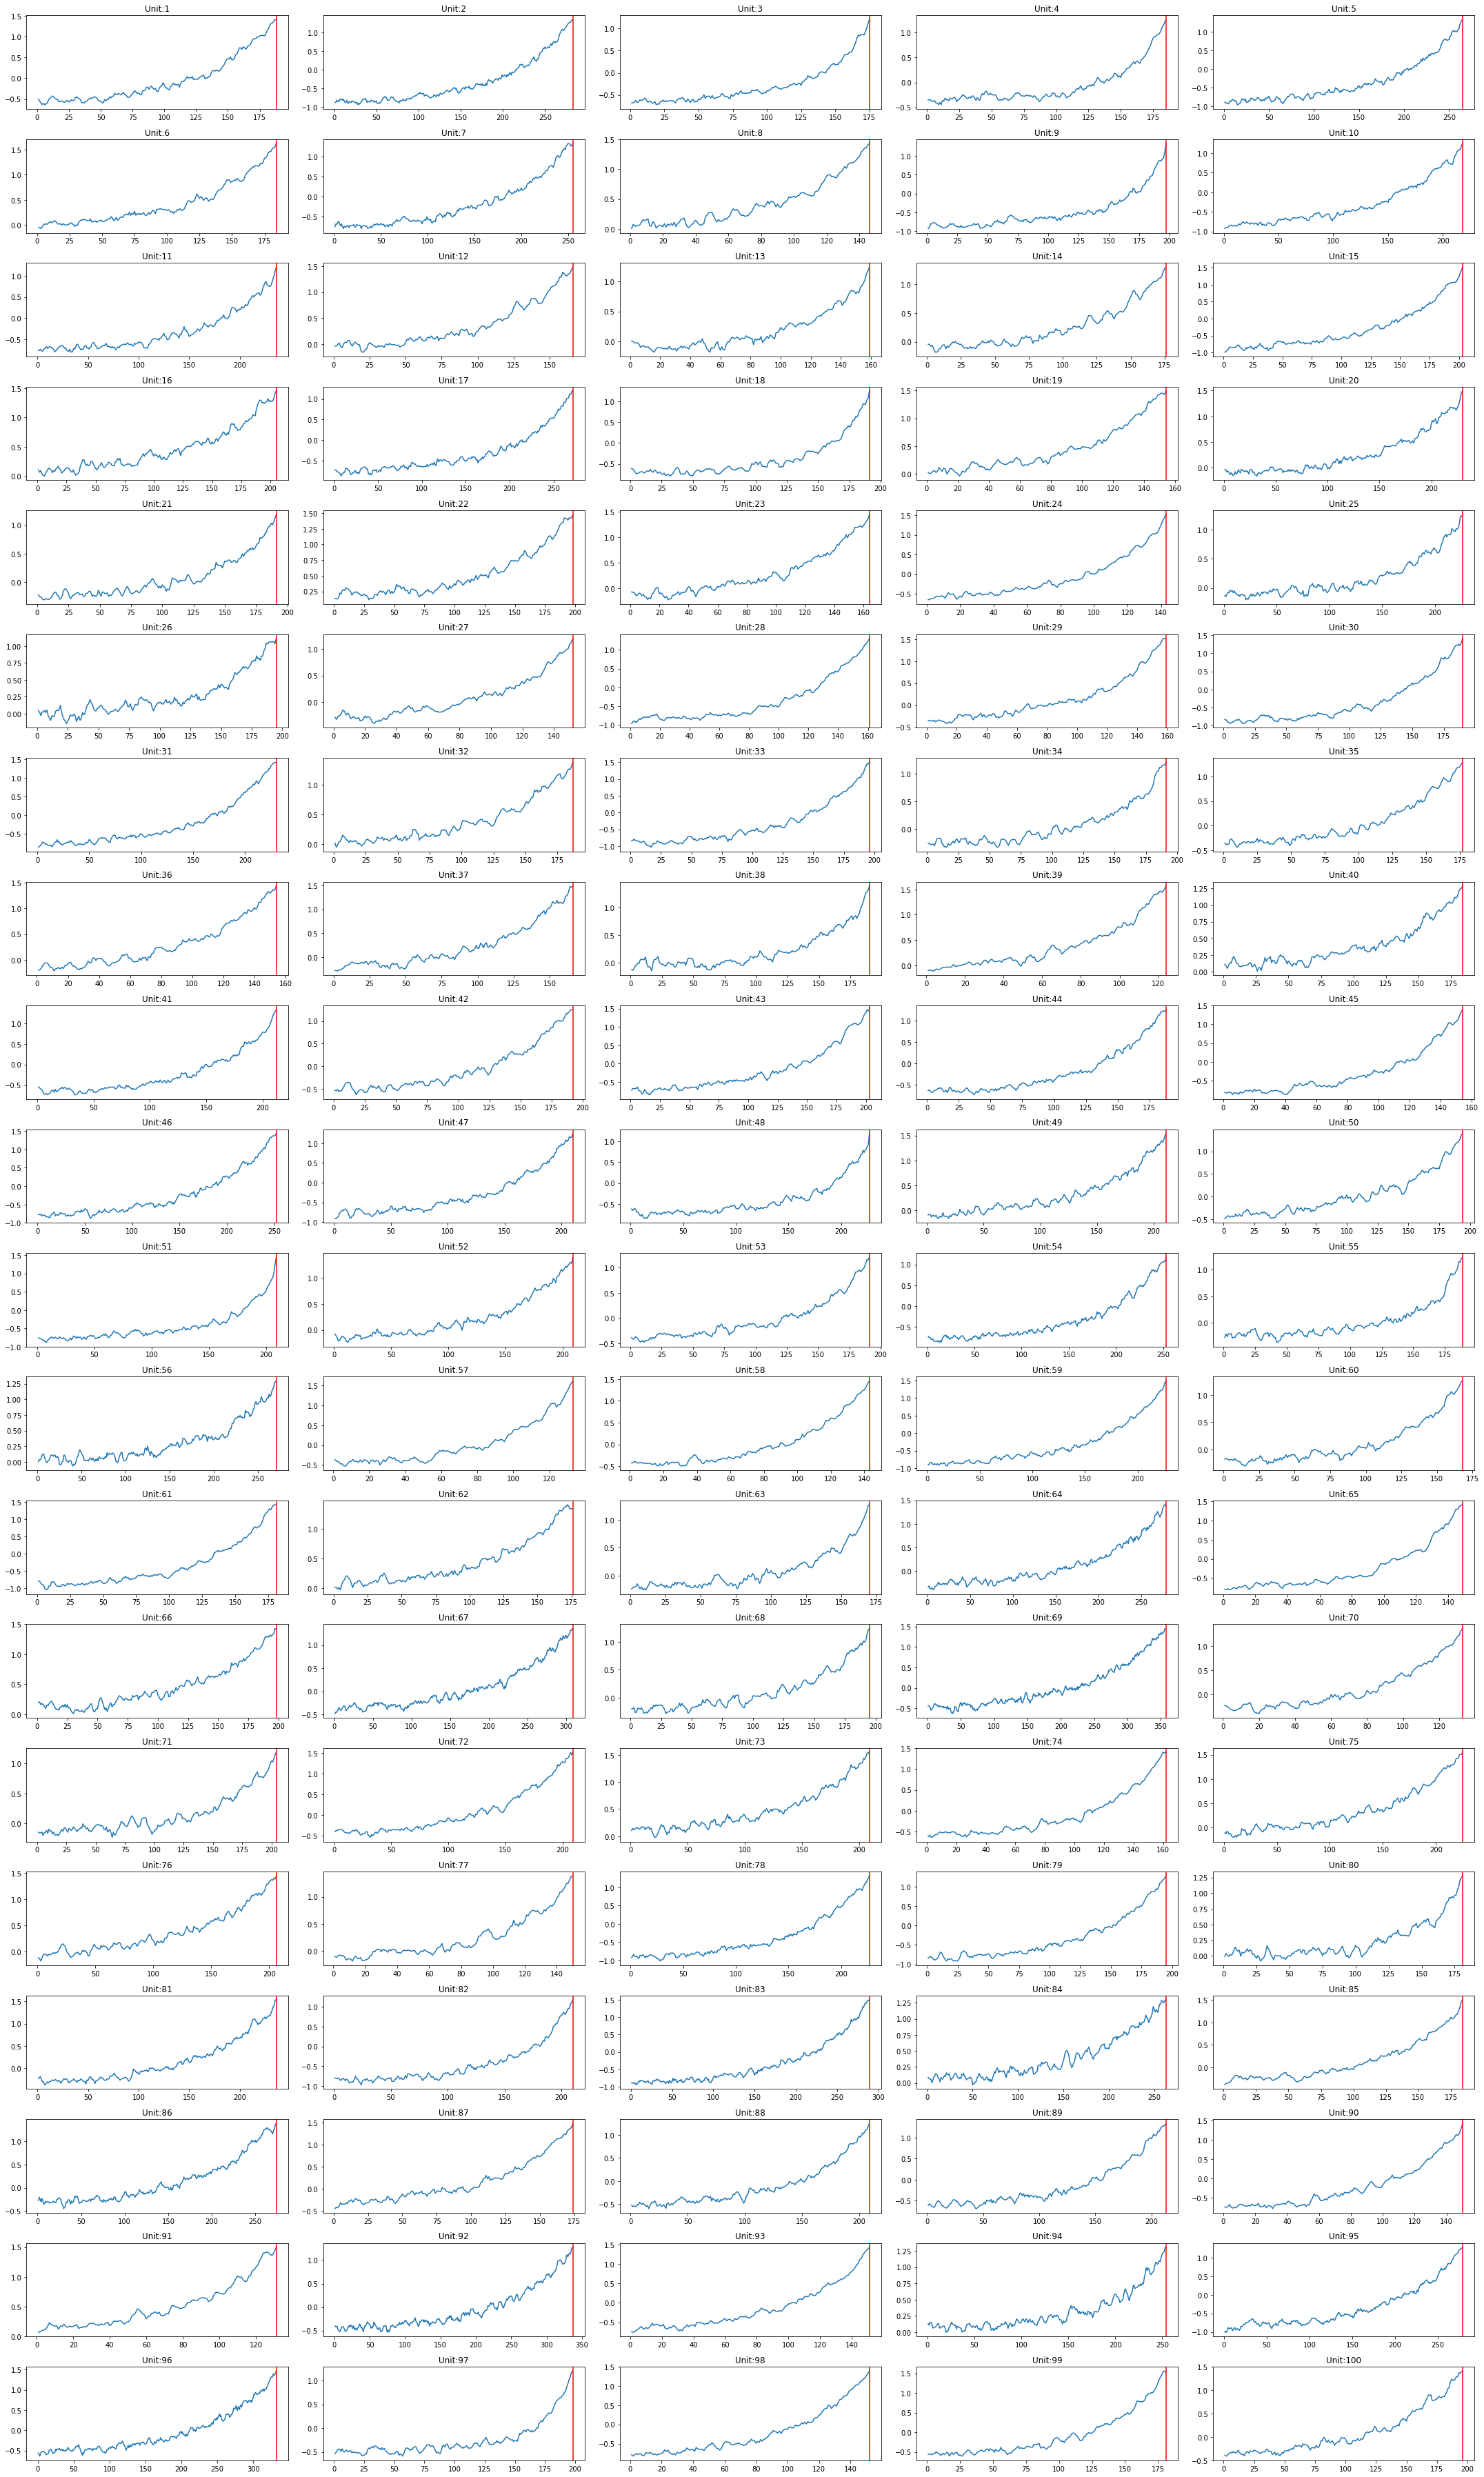

In [41]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    ax[i].axvline(pca_df[pca_df.UnitNumber == i+1].cycle.max(), color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

### Visualizing Health Indicator values at different RULs

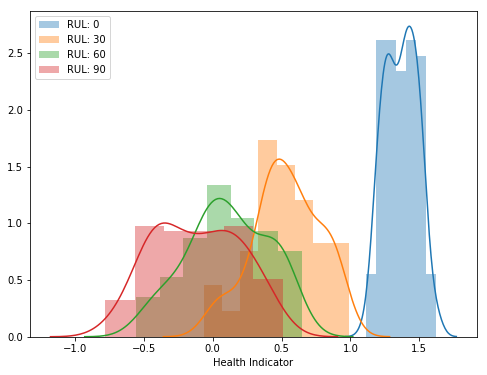

In [59]:
fig, ax = plt.subplots(figsize = (8,6))
sns.distplot(pca_df.pc1[pca_df.RUL == 0], label= "RUL: 0")
sns.distplot(pca_df.pc1[pca_df.RUL == 30], label= "RUL: 30")
sns.distplot(pca_df.pc1[pca_df.RUL == 60], label= "RUL: 60")
sns.distplot(pca_df.pc1[pca_df.RUL == 90], label= "RUL: 90")
plt.xlabel("Health Indicator")
plt.legend()
plt.show()

As we see the spread decreases with the decrease in RUL.

### Failure Threshold

Taking a mean Health Indicator value at RUL=0 as a Failure threshold

In [72]:
threshold = pca_df.pc1[pca_df.RUL == 0].mean()
threshold

1.3662479253124826

In [73]:
threshold_std = pca_df.pc1[pca_df.RUL == 0].std()
threshold_std

0.11653709561659246

### Exponential Degradation

Exponential degradation model can be defined as below

\begin{equation*}
h(t) = \phi + \theta \ exp ( \beta t )
\end{equation*}

- where $h(t)$ is the health indicator as a function of time. 
- $\phi$ is the intercept term considered as a constant. 
- $\theta$ and $\beta$  are random parameters determining the slope of the model, where $\theta$ is lognormal-distributed and $\beta$ is Gaussian-distributed.

Fitting the exponential degradation curve for all units in train data

In [77]:
def exp_degradation(parameters, cycle):
    '''
    Calculate an exponetial degradation of the form:
    ht = phi + theta * exp(beta * cycle)
    ''' 
    phi = parameters[0]
    theta = parameters[1]
    beta = parameters[2]
    
    ht = phi + theta * np.exp(beta * cycle)
    return ht

In [63]:
def residuals(parameters, data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters, data) - y_observed

Initial values for parameters

In [165]:
param_0 = [-1, 0.01, 0.01]

In [166]:
exp_params_df = pd.DataFrame(columns = ['UnitNumber', 'phi', 'theta', 'beta'])

for i in range(1,101):
    
    ht = pca_df.pc1[pca_df.UnitNumber == i]
    cycle = pca_df.cycle[pca_df.UnitNumber == i]

    OptimizeResult = optimize.least_squares(residuals, param_0, args = (cycle, ht, exp_degradation))
    phi, theta, beta = OptimizeResult.x
    
    exp_params_df = exp_params_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta}, ignore_index = True)

In [167]:
exp_params_df.head()

,UnitNumber,phi,theta,beta
0,1.0,-0.635627,0.065714,0.018378
1,2.0,-0.917313,0.046571,0.013751
2,3.0,-0.644046,0.014137,0.027443
3,4.0,-0.336294,0.004275,0.031951
4,5.0,-0.914597,0.046348,0.014524


#### Visualizing fitted exponential curve

Text(0, 0.5, 'Health Indicator')

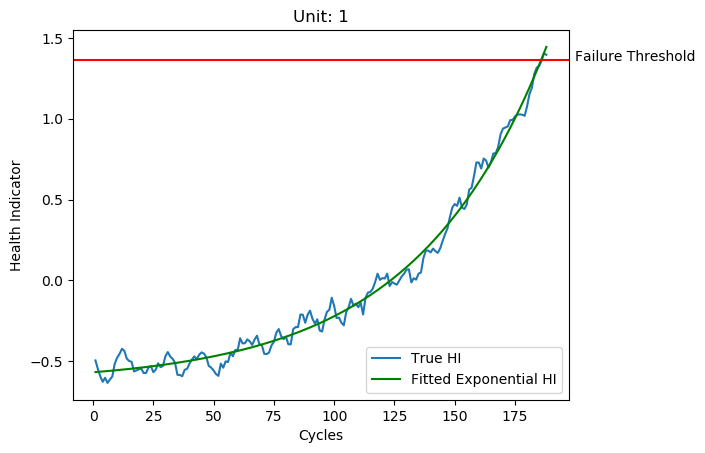

In [175]:
phi = exp_params_df.phi[exp_params_df.UnitNumber == 1].values
theta = exp_params_df.theta[exp_params_df.UnitNumber == 1].values
beta = exp_params_df.beta[exp_params_df.UnitNumber == 1].values

cycles = pca_df.cycle[pca_df.UnitNumber == 1]
pred_ht = exp_degradation([phi, theta, beta], cycles)

fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "cycle", y = "pc1", ax = ax, label = "True HI")
sns.lineplot(y = pred_ht, x = cycles, ax = ax, color = "green", label = "Fitted Exponential HI")
ax.axhline(threshold, color = 'r')
ax.text(200,threshold - 0.01,'Failure Threshold',rotation=0)
ax.set_title("Unit: 1")
ax.set_xlabel("Cycles")
ax.set_ylabel("Health Indicator")

For all Units

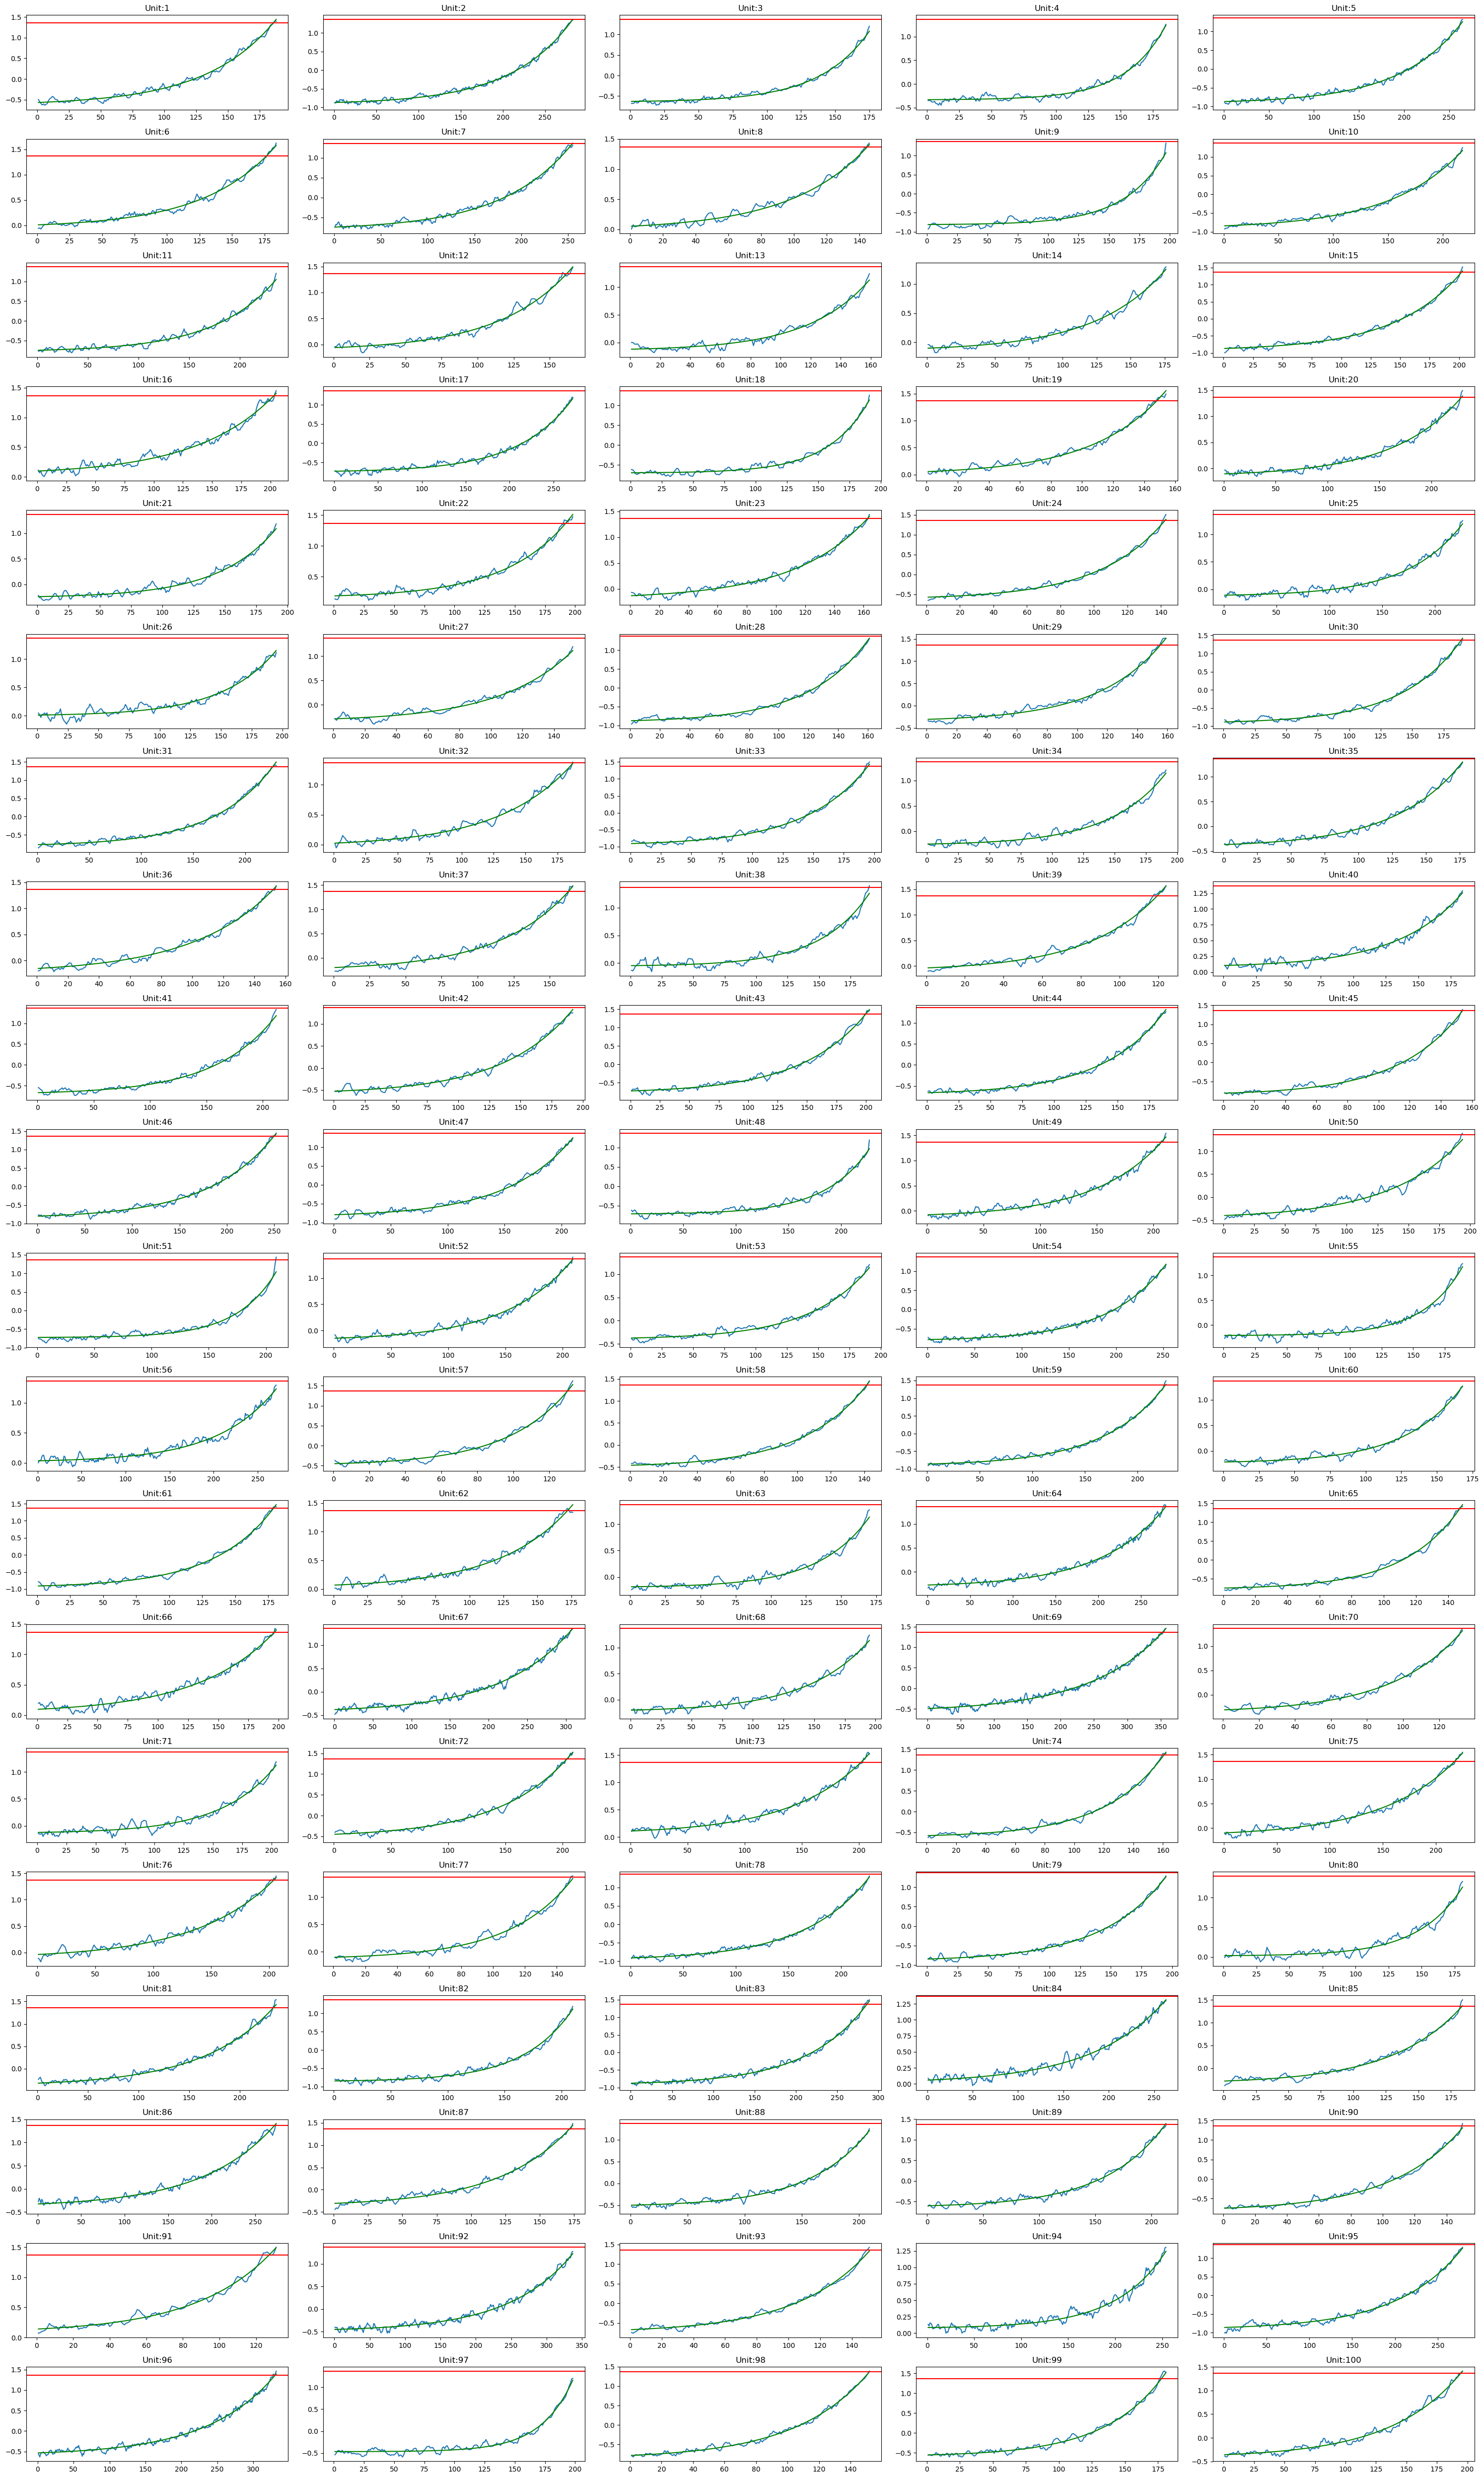

In [169]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    
    phi = exp_params_df.phi[exp_params_df.UnitNumber == i+1].values
    theta = exp_params_df.theta[exp_params_df.UnitNumber == i+1].values
    beta = exp_params_df.beta[exp_params_df.UnitNumber == i+1].values
    
    cycles = pca_df.cycle[pca_df.UnitNumber == i+1]
    pred_ht = exp_degradation([phi, theta, beta], cycles)
    
    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    sns.lineplot(y = pred_ht, x = cycles, ax = ax[i], color = "green")
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

The exponential curves result in good fit. Since, The last value of health indicator is different in all units, we do not see threhsold in plots.

#### Visualizing various parameters distributions

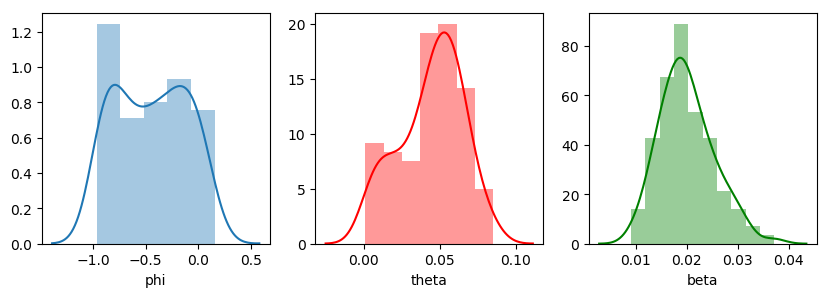

In [182]:
fig, ax = plt.subplots(figsize = (10,3), nrows = 1, ncols = 3)
sns.distplot(exp_params_df.phi, ax = ax[0])
sns.distplot(exp_params_df.theta, ax = ax[1], color = "red")
sns.distplot(exp_params_df.beta, ax = ax[2], color = "green")

### Preparaing Test data

In [172]:
window = 5

df_test_mean = df_test.groupby('UnitNumber')[feats].rolling(window = window).mean()
df_test_mean = df_test_mean.reset_index()
df_test_mean.dropna(inplace = True)
df_test_mean.drop(['level_1'], axis = 1, inplace = True)
df_test_mean.head()

,UnitNumber,SensorMeasure14,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure4,SensorMeasure13,SensorMeasure8
4,1,-0.673836,-0.743803,-0.395238,0.358635,-0.378393,-0.529412,-0.612121
5,1,-0.669894,-0.742385,-0.380952,0.375693,-0.399190,-0.500000,-0.636364
6,1,-0.679492,-0.747824,-0.426190,0.362900,-0.335584,-0.500000,-0.612121
7,1,-0.688100,-0.755183,-0.495238,0.373134,-0.338623,-0.482353,-0.612121
8,1,-0.685520,-0.749331,-0.473810,0.428571,-0.299055,-0.482353,-0.593939


In [174]:
pca_test_data = pca.transform(df_test_mean[feats])

pca_test_df = pd.DataFrame(pca_test_data, columns = ['pc1', 'pc2', 'pc3'])
pca_test_df['UnitNumber'] = df_test_mean.UnitNumber.values
pca_test_df['cycle'] = pca_test_df.groupby('UnitNumber').cumcount()+1
pca_test_df.head()

,pc1,pc2,pc3,UnitNumber,cycle
0,-0.480441,-0.124101,0.064602,1,1
1,-0.489994,-0.122203,0.071390,1,2
2,-0.469134,-0.134640,0.025408,1,3
3,-0.507406,-0.152732,0.013009,1,4
4,-0.498859,-0.145213,-0.051034,1,5


### Predicting RUL

Steps

1. Fit all exponential models found using train data set.
2. Find out total remaining cycles to reach failure threshold
3. Take a mean of it as a predicted RUL
4. Find out 95% confidence interval
5. Repeat 1 to 4 for all test units
6. Calculate total MAPE

In [ ]:
for i in pca_test_df.UnitNumber.unique():
    
    